# Decompose the diagnosed omz change

In [2]:
import pathlib
from cmip6_omz.utils import o2_models
import xarray as xr
import cf_xarray
import matplotlib.pyplot as plt
from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [3]:
# from distributed import Client, LocalCluster

# # This is optimized so that 
# mem_total = 140
# workers = 3
# threads = 10
# cluster = LocalCluster(
#     memory_limit=f"{int(mem_total/workers)}GB",
#     dashboard_address=9999,
#     threads_per_worker=threads,
#     n_workers = workers,
#                       )
# client = Client(cluster)
# client

In [4]:
# import dask
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(8))

In [5]:
from cmip6_omz.omz_tools import mask_basin

def mask_pacific(ds_in, tropics):
    ds_masked = mask_basin(ds_in, drop=False)
    if tropics:
        ds_masked = ds_masked.where(abs(ds_masked.lat) <= 30, drop=False)
    return ds_masked

def anomaly(ds):
    return ds - ds.isel(time=slice(0,10)).mean('time')

In [ ]:
with ProgressBar():
    prep(ds_single, True).load()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[                                        ] | 0% Completed | 11.8s

In [6]:
flist = pathlib.Path('/tigress/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/data/processed/fine_density_tests_combined_2/').glob('*.zarr')
flist = list(flist)
results = {}
models = [m for m in o2_models() if 'HR' not in m]
for model in models:
    sublist = [f for f in flist if f".{model}." in str(f)]

    if len(sublist) != 2:
        print(f"NOPE to {model} ({len(sublist)})")
    else:
        print(f"YAAAS to {model} ({len(sublist)})")
        datasets = []
        for fs in sublist:
            ds_single = xr.open_zarr(fs, use_cftime=True)
            ex = 'fixed_o2' if 'synthetic' in str(fs) else 'variable_o2'
            ds_single = ds_single.assign_coords(experiment=ex)
            datasets.append(ds_single)
        ds = xr.concat(datasets, 'experiment', compat='override', coords='minimal')
        # add decomposed signal
        results[model] = ds

YAAAS to CanESM5-CanOE (2)
YAAAS to CanESM5 (2)
YAAAS to CNRM-ESM2-1 (2)
YAAAS to ACCESS-ESM1-5 (2)
NOPE to MPI-ESM-1-2-HAM (0)
YAAAS to IPSL-CM6A-LR (2)
YAAAS to MIROC-ES2L (2)
YAAAS to UKESM1-0-LL (2)
YAAAS to MPI-ESM1-2-LR (2)
NOPE to MRI-ESM2-0 (0)
NOPE to NorCPM1 (0)
NOPE to NorESM1-F (0)
NOPE to NorESM2-LM (1)
YAAAS to NorESM2-MM (2)
NOPE to GFDL-CM4 (0)
NOPE to GFDL-ESM4 (0)


In [7]:
def prep(ds, tropics, summed=True):
    if 'areacello' in ds.variables:
        area = ds.areacello
    else:
        area = ds.dx_t * ds.dy_t
        
    ds['vol'] = ds.omz_thickness * area
    
    vol = ds.vol
    vol_masked = mask_pacific(vol, tropics)
    
    # add the dz
    dsig = cf_xarray.bounds_to_vertices(ds.sigma_0_bounds, 'bnds').diff('sigma_0_vertices').load()
    vol_masked = vol_masked.assign_coords(dsigma = ('sigma_0',dsig.data))
    if summed:
        return vol_masked.sum(['x','y'])
    else:
        return vol_masked

In [8]:
from dask.diagnostics import ProgressBar

In [9]:
vol_integrated_tropics = {}
vol_integrated_full = {}
    
with ProgressBar():
    for model, ds in results.items():
        print(model)
        vol_integrated_tropics[model] = prep(ds, True)#.load()
        vol_integrated_full[model] = prep(ds, False)#.load()

CanESM5-CanOE
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
CanESM5
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
CNRM-ESM2-1
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[#############

In [12]:
ds.chunk({'o2_bin':-1})

<xarray.Dataset>
Dimensions:         (experiment: 2, y: 385, x: 360, time: 251, sigma_0: 45, x_right: 360, y_left: 385, bnds: 2, vertex: 4, o2_bin: 6)
Coordinates: (12/27)
    areacello       (x, y) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    dx_gx           (x_right, y) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    dx_gxgy         (x_right, y_left) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    dx_gy           (x, y_left) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    dx_t            (x, y) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    dy_gx           (x_right, y) float64 dask.array<chunksize=(180, 193), meta=np.ndarray>
    ...              ...
  * time            (time) object 1850-07-01 17:00:00 ... 2100-07-01 17:00:00
  * x               (x) int32 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
  * x_right         (x_right) float64 1.5 2.5 3.5 4.5 ... 358.5 359.5 360.5
  * y               (y) int32 1 2 3 4 5 6 7 8 ... 379 380 381 382 383 384 385
  * y_left          (y_left) float64 0.5 1.5 2.5 3.5 ... 381.5 382.5 383.5 384.5
  * experiment      (experiment) <U11 'variable_o2' 'fixed_o2'
Dimensions without coordinates: bnds, vertex
Data variables:
    agessc          (experiment, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 385, 360, 1, 45), meta=np.ndarray>
    o2              (experiment, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 385, 360, 1, 45), meta=np.ndarray>
    omz_thickness   (experiment, o2_bin, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 6, 385, 360, 1, 45), meta=np.ndarray>
    so              (experiment, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 385, 360, 1, 45), meta=np.ndarray>
    thetao          (experiment, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 385, 360, 1, 45), meta=np.ndarray>
    vol             (experiment, o2_bin, y, x, time, sigma_0) float64 dask.array<chunksize=(1, 6, 193, 180, 1, 45), meta=np.ndarray>
Attributes: (12/38)
    Conventions:               CF-1.7 CMIP-6.2
    branch_time:               [0.0]
    branch_time_in_child:      [0.0]
    cmor_version:              3.5.0
    contact:                   Please send any requests or bug reports to nor...
    data_specs_version:        01.00.31
    ...                        ...
    sub_experiment:            none
    sub_experiment_id:         none
    table_id:                  Omon
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variant_label:             r1i1p1f1

In [10]:
vol_integrated_full['CNRM-ESM2-1']#.nbytes/1e6

,Array,Chunk
Bytes,1.03 MiB,360 B
Shape,"(2, 6, 251, 45)","(1, 1, 1, 45)"
Count,54230 Tasks,3012 Chunks
Type,float64,numpy.ndarray


In [ ]:
%matplotlib inline

In [ ]:
fig, axarr = plt.subplots(figsize=[13, 3*len(results)], ncols=2, nrows=len(results))

for mi, model in enumerate(results.keys()):
    
    for pi, title, da in zip([0,1], ['tropical', 'full'],[vol_integrated_tropics[model], vol_integrated_full[model]]):
        ax = axarr[mi, pi]
        da.sel(o2_bin=80).sum('sigma_0').plot(ax=ax,hue='experiment')
        ax.set_title(f'{model} ({title} Pacific)')
        ax.set_ylabel('Vertically integrated \n OMZ Volume [m^3]')
fig.subplots_adjust(hspace=0.5, wspace =0.5)

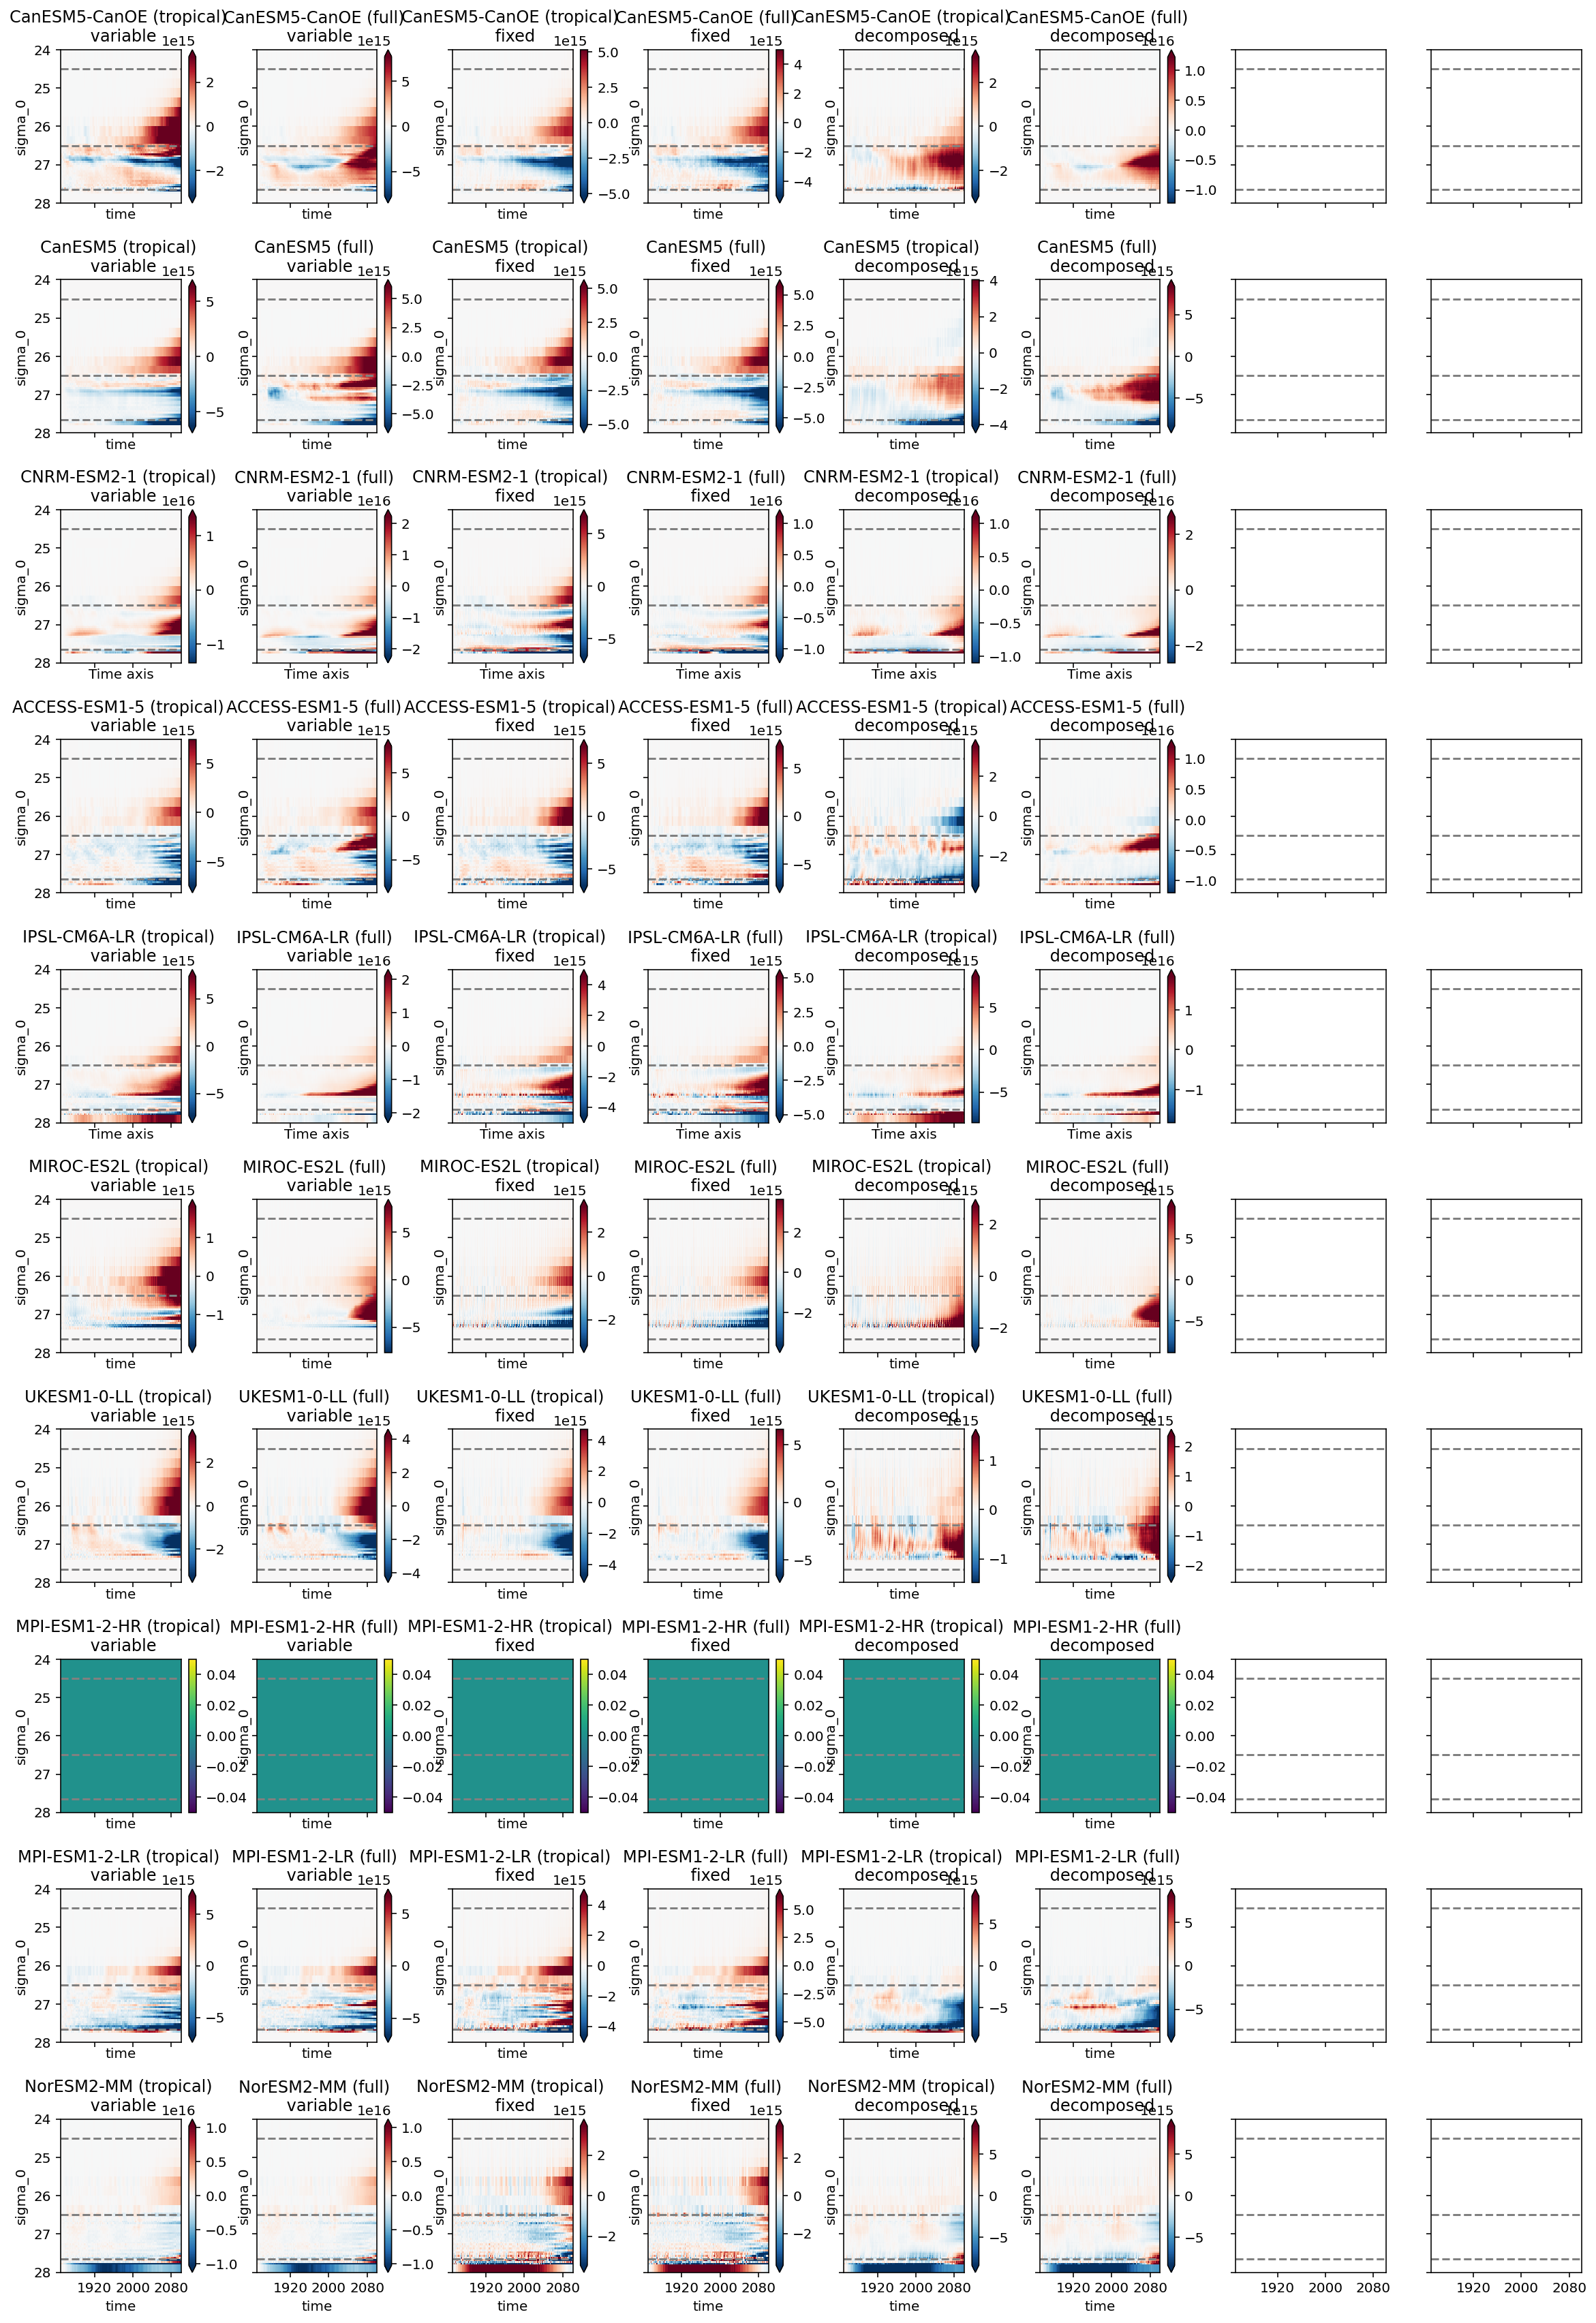

In [8]:
fig, axarr = plt.subplots(figsize=[20, 3*len(results)], ncols=8, nrows=len(results), sharey=True ,sharex=True)

for mi, model in enumerate(results.keys()):
    for pi, (title, da) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics[model], vol_integrated_full[model]])):
        fixed = da.sel(experiment='fixed_o2')
        variable = da.sel(experiment='variable_o2')
        decomposed = variable - fixed
        
        #plot variable o2
        ax = axarr[mi, 0+pi]
        (anomaly(variable)/variable.dsigma).plot(ax=ax, y='sigma_0', robust=True)
        
        ax.set_ylim(28.5,23)
        ax.set_title(f'{model} ({title}) \n variable')
        
        #plot variable o2
        ax = axarr[mi, 2+pi]
        (anomaly(fixed)/fixed.dsigma).plot(ax=ax, y='sigma_0', robust=True)
        
        ax.set_ylim(28.5,23)
        ax.set_title(f'{model} ({title}) \n fixed')
        
        #plot decomposed
        ax = axarr[mi, 4+pi]
        (anomaly(decomposed)/decomposed.dsigma).plot(ax=ax, y='sigma_0', robust=True)
        
        ax.set_ylim(28,24)
        ax.set_title(f'{model} ({title}) \n decomposed')
        
        # still missing the depth data
for ax in axarr.flat:
    for l in [24.5, 26.5, 27.65]:
        ax.axhline(l, color='0.5', ls='--')
fig.subplots_adjust(hspace=0.5, wspace =0.3)

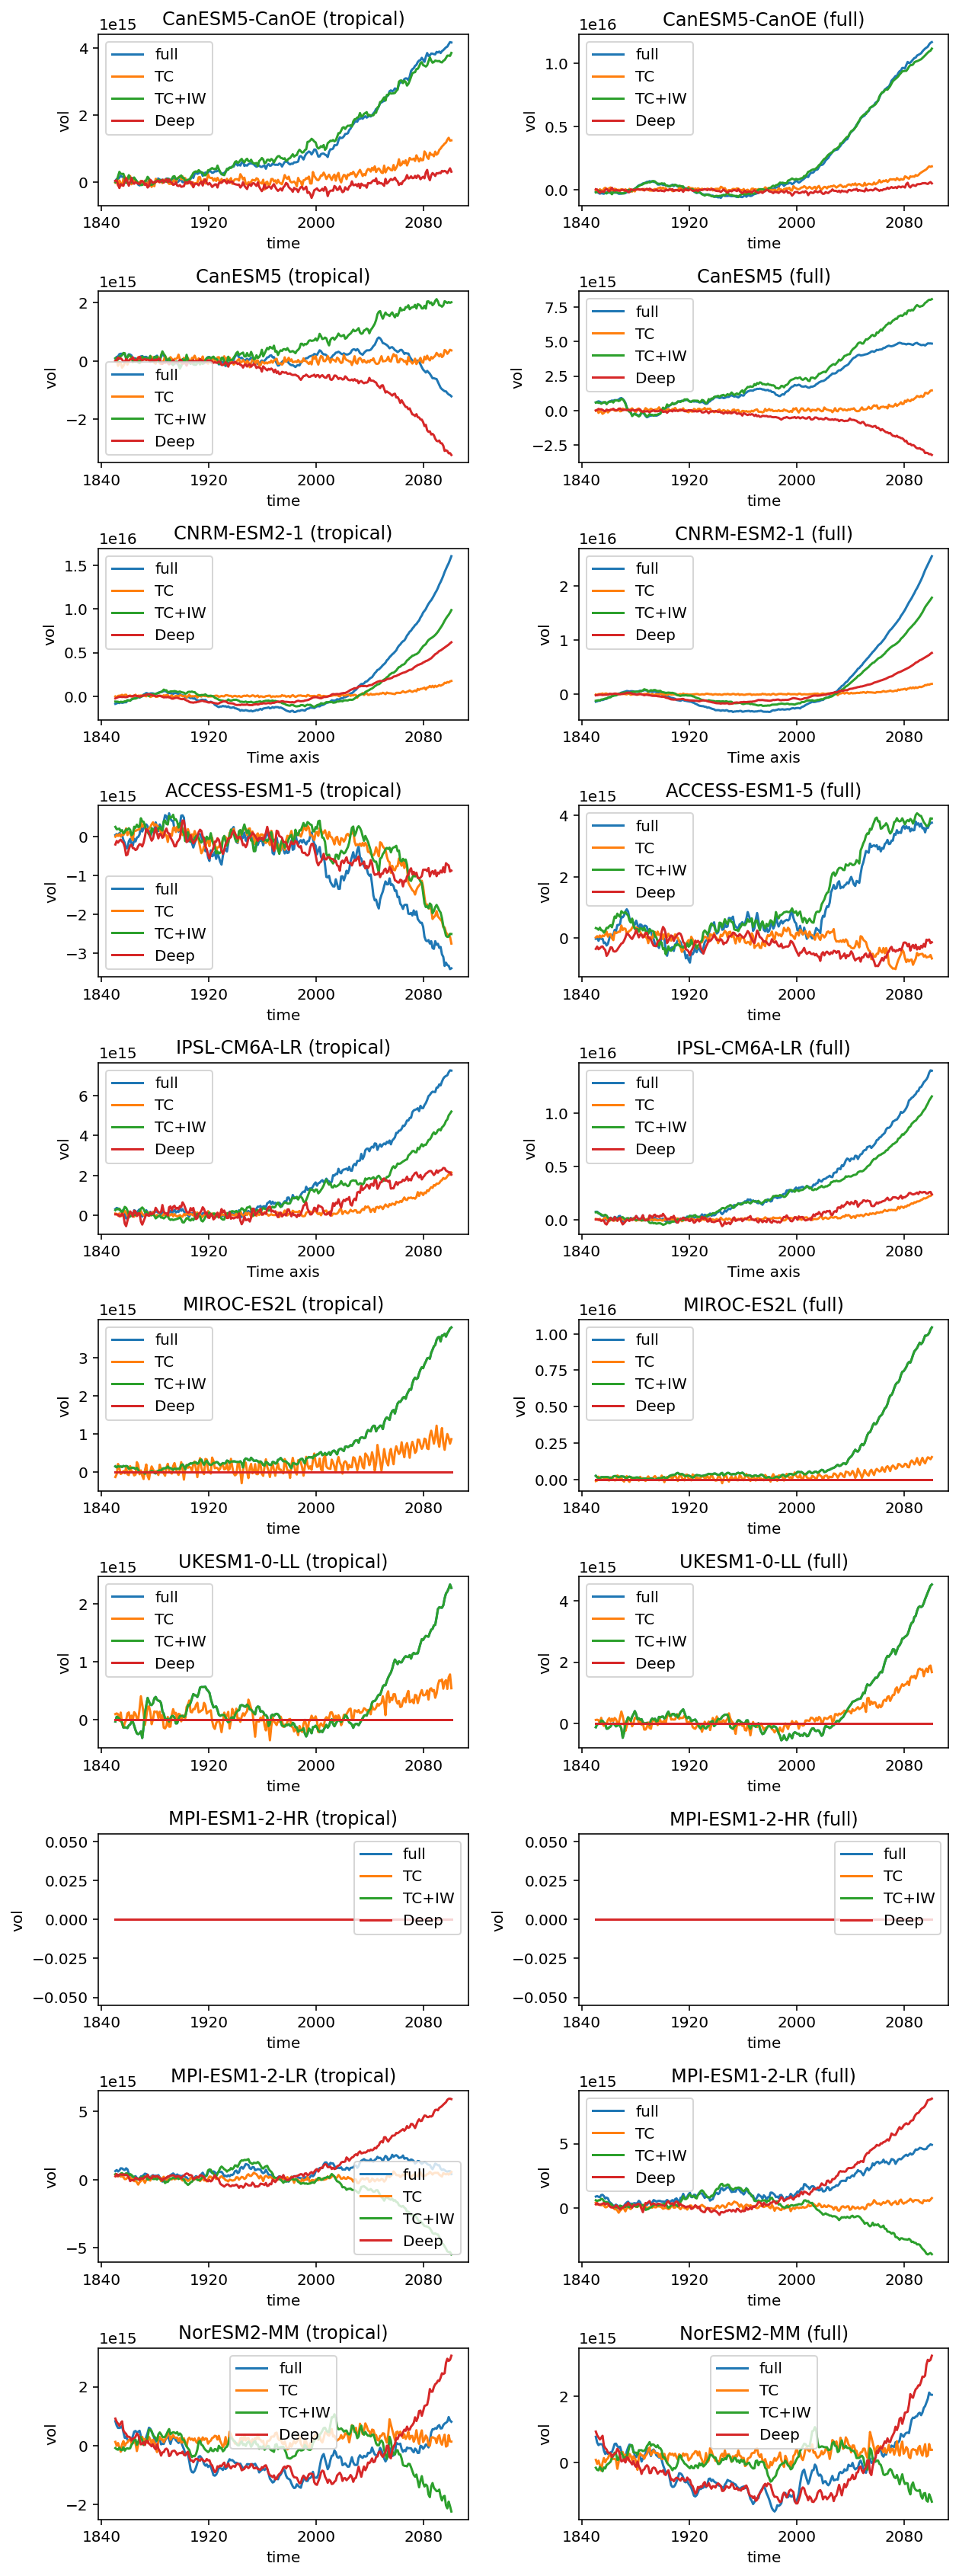

In [9]:
fig, axarr = plt.subplots(figsize=[10, 3*len(results)], ncols=2, nrows=len(results))#, sharey=True

for mi, model in enumerate(results.keys()):
    for pi, (title, da) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics[model], vol_integrated_full[model]])):
        fixed = da.sel(experiment='fixed_o2')
        variable = da.sel(experiment='variable_o2')
        decomposed = variable - fixed
        
        ax = axarr[mi, pi]
        decomposed.sum('sigma_0').plot(label='full', ax=ax)
        decomposed.sel(sigma_0=slice(0, 26.5)).sum('sigma_0').plot(label='TC', ax=ax) 
        decomposed.sel(sigma_0=slice(0, 27.5)).sum('sigma_0').plot(label='TC+IW', ax=ax) 
        decomposed.sel(sigma_0=slice(27.5, None)).sum('sigma_0').plot(ax=ax, label='Deep')
        ax.legend()
        ax.set_title(f'{model} ({title})')
        
fig.subplots_adjust(hspace=0.5, wspace =0.3)

## Combined plots

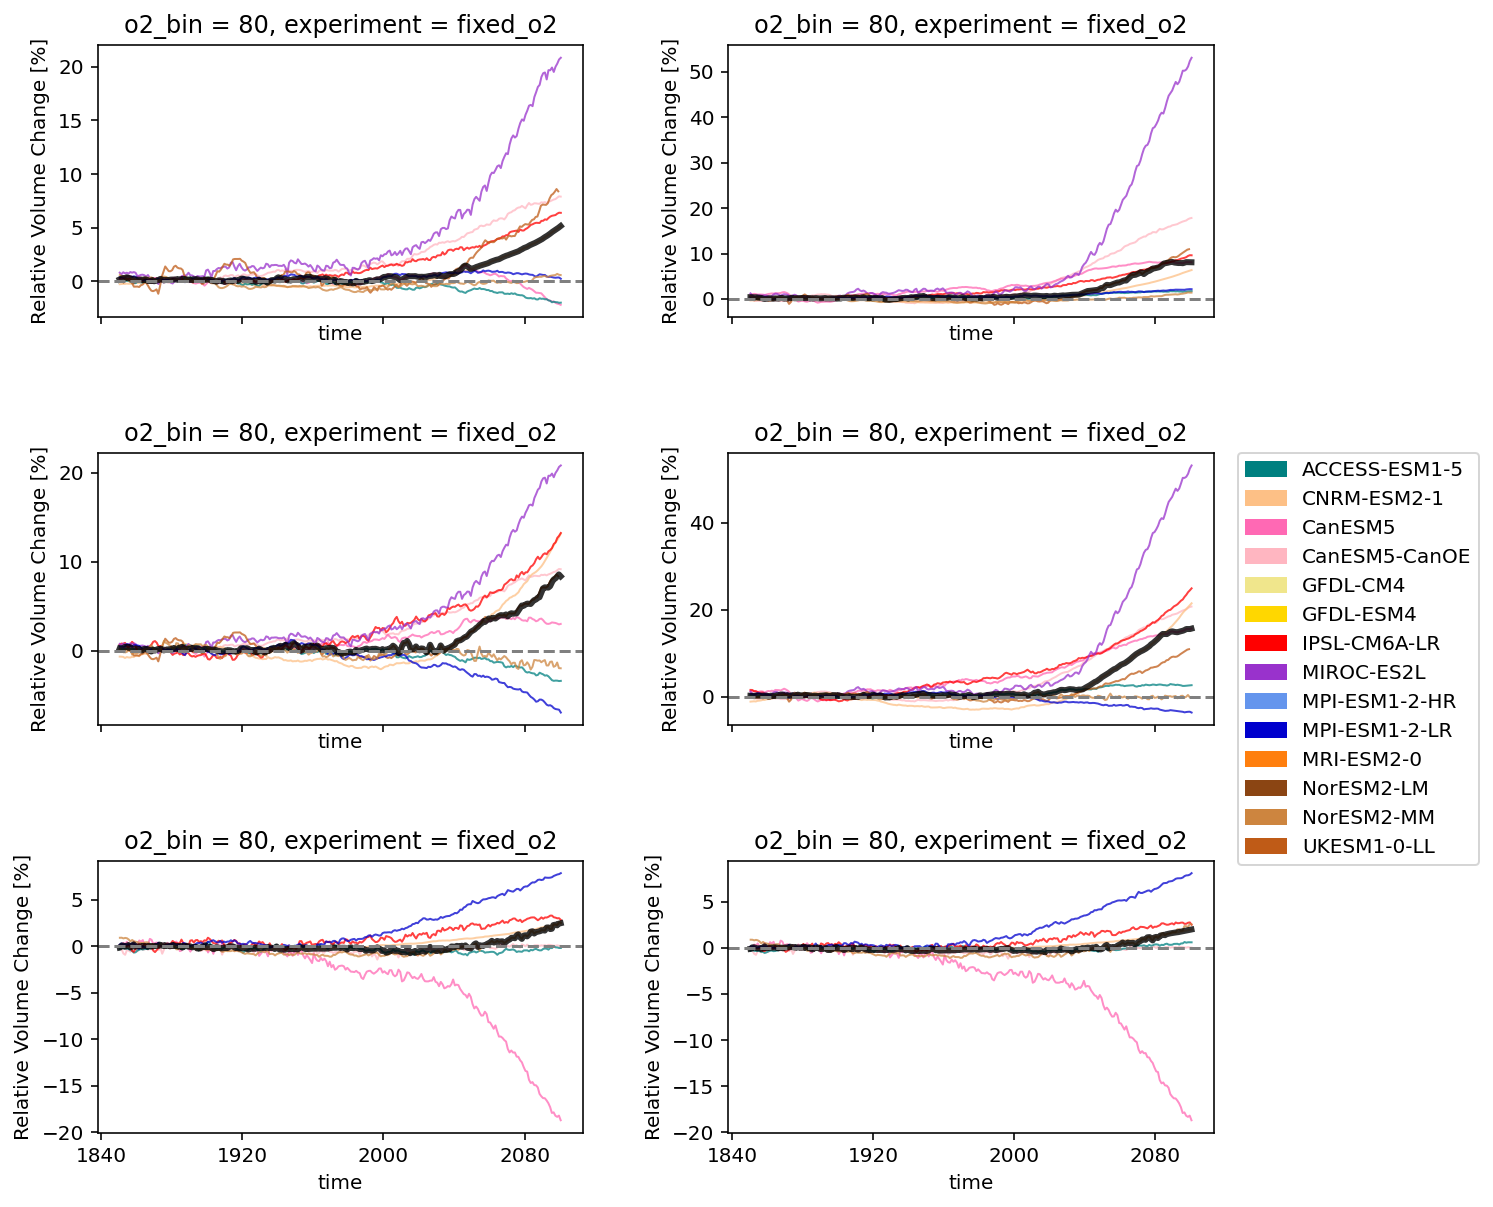

In [10]:
percentage = True
from cmip6_preprocessing.drift_removal import replace_time
fig, axarr = plt.subplots(
    figsize=[10, 10], ncols=2, nrows=3, sharex=True
)  # , sharey=True

for pi, (title, res) in enumerate(
    zip(["tropical", "full"], [vol_integrated_tropics, vol_integrated_full])
):
    datasets_full = []
    datasets_upper = []
    datasets_deep = []
    for mi, model in enumerate(results.keys()):

        ds = res[model]

        fixed = ds.sel(experiment="fixed_o2")
        variable = ds.sel(experiment="variable_o2")
        decomposed = variable - fixed
        color = o2_model_colors()[model]

        def _plot(ds):
            return ds.sum("sigma_0")#.rolling(time=3, ).mean()
        
        kwargs = dict(color=color, lw=1.0, alpha=0.75, x="time")
        
        ax = axarr[0, pi]
        da = _plot(decomposed) 
        if percentage:
            da = da/_plot(fixed.isel(time=0)) * 100
        da.plot(ax=ax, **kwargs)
        datasets_full.append(da)
        ax.set_title(f" Full ({title})")

        ax = axarr[1, pi]
        da = _plot(
            decomposed.sel(sigma_0=slice(0, 27.65))
        ) 
        if percentage:
            da = da/_plot(fixed.isel(time=0).sel(sigma_0=slice(0, 27.5))) * 100
        da.plot(ax=ax, **kwargs)
        datasets_upper.append(da)
        ax.set_title(f" Upper ({title})")

        ax = axarr[2, pi]
        da = _plot(
            decomposed.sel(sigma_0=slice(27.65, None))
        ) 
        if percentage:
            da = da/_plot(fixed.isel(time=0).sel(sigma_0=slice(27.5, None))) * 100
        da.plot(ax=ax, **kwargs)
        datasets_deep.append(da)
        ax.set_title(f" Deep ({title})")

    # add median lines
    
    xr.concat(
        [replace_time(ds.resample(time='1M').interpolate('linear'), calendar="standard") for ds in datasets_full], "model"
    ).median("model").plot(ax=axarr[0, pi], color="k", lw=3, alpha=0.8)
    
    xr.concat(
        [replace_time(ds.resample(time='1M').interpolate('linear'), calendar="standard") for ds in datasets_upper], "model"
    ).median("model").plot(ax=axarr[1, pi], color="k", lw=3, alpha=0.8)
    
    xr.concat(
        [replace_time(ds.resample(time='1M').interpolate('linear'), calendar="standard") for ds in datasets_deep], "model"
    ).median("model").plot(ax=axarr[2, pi], color="k", lw=3, alpha=0.8)


fig.subplots_adjust(hspace=0.5, wspace=0.3)

for ax in axarr.flat:
    ax.axhline(0, color="0.5", ls="--")
    if percentage:
        ax.set_ylabel("Relative Volume Change [%]")
    else:
        ax.set_ylabel("Total Volume Change [$m^3$]")
model_color_legend(axarr[1, 1])

In [11]:
from xarrayutils.utils import linear_trend
import numpy as np

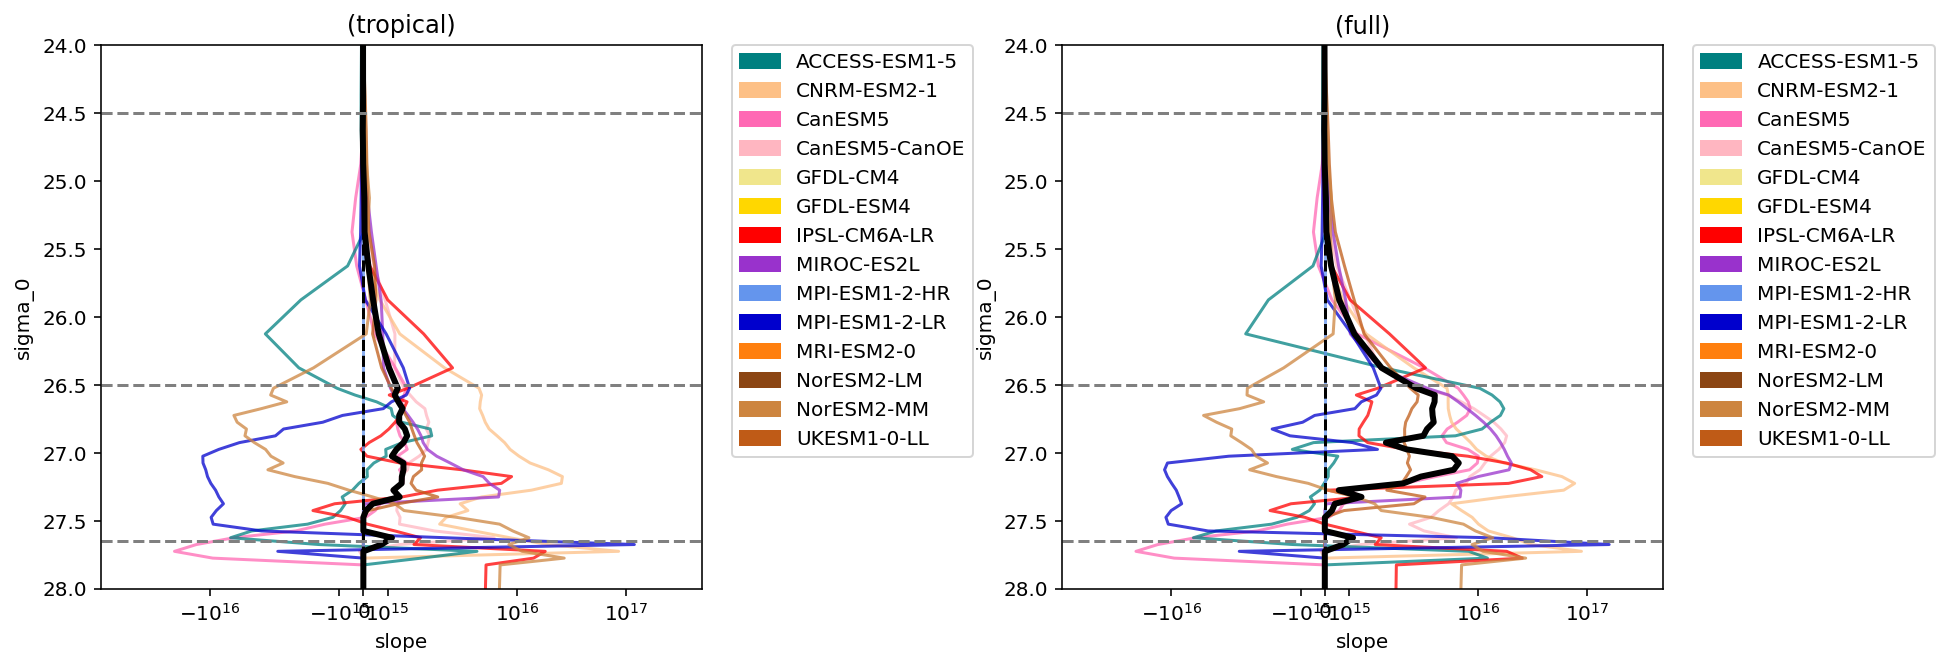

In [12]:
fig, axarr = plt.subplots(figsize=[14, 5], ncols=2, nrows=1)


for pi, (title, ds) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics, vol_integrated_full])):
    datasets = []
    ax = axarr.flat[pi]
    for mi, model in enumerate(results.keys()):
        da = ds[model]
        fixed = da.sel(experiment='fixed_o2')
        variable = da.sel(experiment='variable_o2')
        decomposed = variable - fixed
        
        decomposed_normed = decomposed/decomposed.dsigma
        
        decomposed_trend = linear_trend(decomposed_normed.sel(time=slice('2000', '2100')),'time').slope * 100
        
        
        decomposed_trend.plot(ax=ax, y='sigma_0', color=o2_model_colors()[model], lw=1.5, alpha=0.75)
        datasets.append(decomposed_trend)

    xr.concat(datasets, 'model').median('model').plot(ax=ax, color='k', lw=3, y='sigma_0')
    
    
    ax.set_ylim(28,24)
    ax.axvline(0,color='k', ls='--')
    ax.set_title(f'({title})')
    ax.set_xlim(np.array([-0.1, 0.5])*1e18)
    ax.set_xscale('symlog', linthresh=5e15)

    
    for l in [24.5, 26.5, 27.65]:
        ax.axhline(l, color='0.5', ls='--')
    model_color_legend(ax)
fig.subplots_adjust(hspace=0.5, wspace =0.6)

In [13]:
woa_sigma = xr.open_dataset('/tigress/GEOCLIM/LRGROUP/shared_data/samjd_cmip6_density_transform/WOA/woa13_fine_sigma.nc')
# woa_sigma

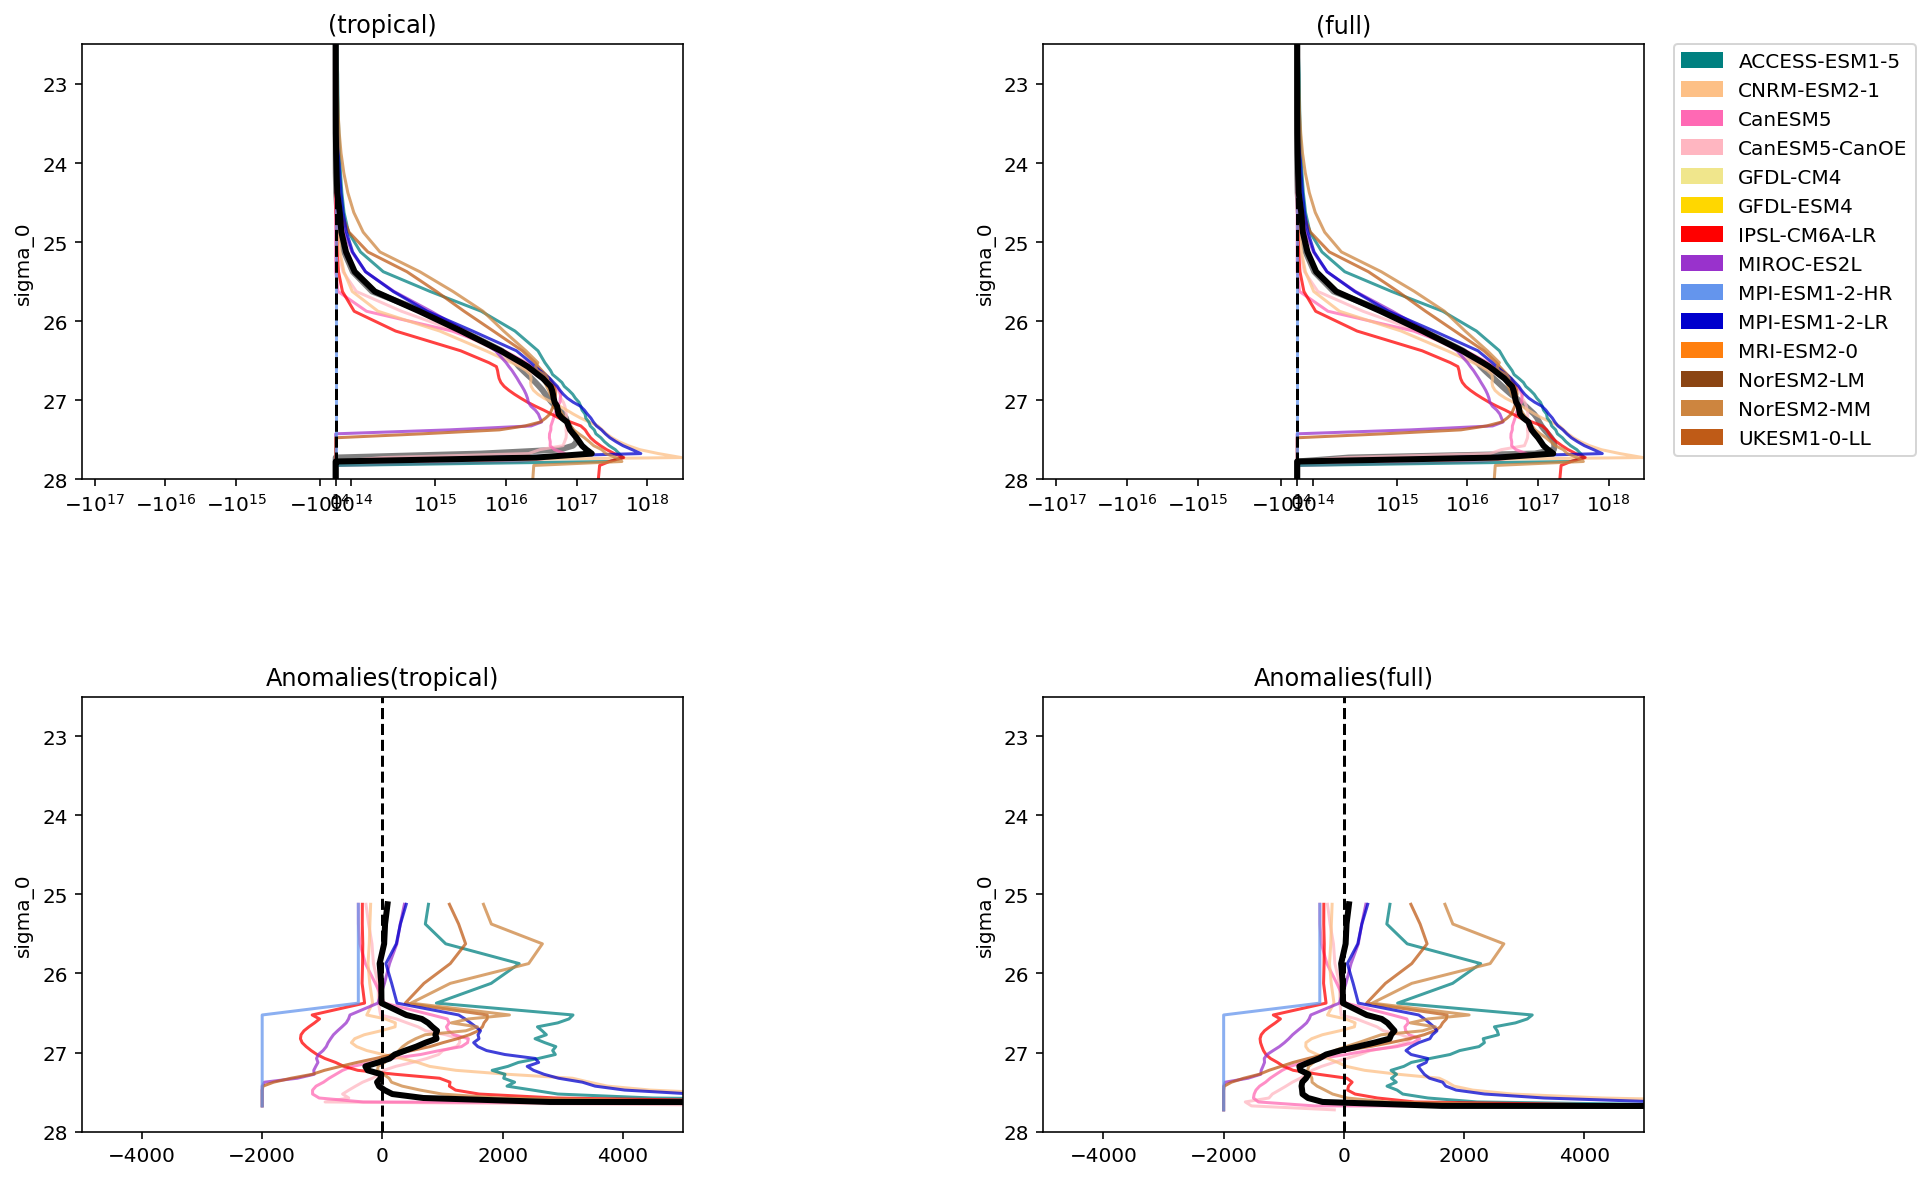

In [14]:
fig, axarr = plt.subplots(figsize=[14, 10], ncols=2, nrows=2)


for pi, (title, res) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics, vol_integrated_full])):
    datasets = []
    ax = axarr[0,pi]
    ax_an = axarr[1,pi]
    
    
    
    if title == 'tropical':
        obs = prep(woa_sigma, True)
    elif title == 'full':
        obs = prep(woa_sigma, False)
        
    dsigma = obs.dsigma
        
    (obs/dsigma).plot(ax=ax, color='0.5', lw=3, y='sigma_0')
        
    for mi, model in enumerate(results.keys()):
        da = ds[model]
        fixed = da.sel(experiment='fixed_o2').isel(time=0)
        (fixed/dsigma).plot(ax=ax, y='sigma_0', color=o2_model_colors()[model], lw=1.5, alpha=0.75)
        datasets.append(fixed)
        
        fixed_an = ((fixed-obs)/obs*100)
        # mask out regions that are very small
        fixed_an = fixed_an.where(obs>1e13)
        (fixed_an/dsigma).plot(ax=ax_an, y='sigma_0', color=o2_model_colors()[model], lw=1.5, alpha=0.75)
        
    mmm = xr.concat(datasets, 'model').median('model')
    (mmm/dsigma).plot(ax=ax, color='k', lw=3, y='sigma_0')
    
    #mmm anomaly
    mmm_an = ((mmm-obs)/obs*100)
    mmm_an = mmm_an.where(obs>1e13)
    (mmm_an/dsigma).plot(ax=ax_an, color='k', lw=3, y='sigma_0')
    
    ax.set_ylim(28,22.5)
    ax.axvline(0,color='k', ls='--')
    ax.set_title(f'({title})')
    ax.set_xscale('symlog', linthresh=5e14)
    
    ax_an.set_ylim(28,22.5)
    ax_an.set_xlim(-5000,5000)
    ax_an.axvline(0,color='k', ls='--')
    ax_an.set_title(f'Anomalies({title})')

model_color_legend(ax)
fig.subplots_adjust(hspace=0.5, wspace =0.6)

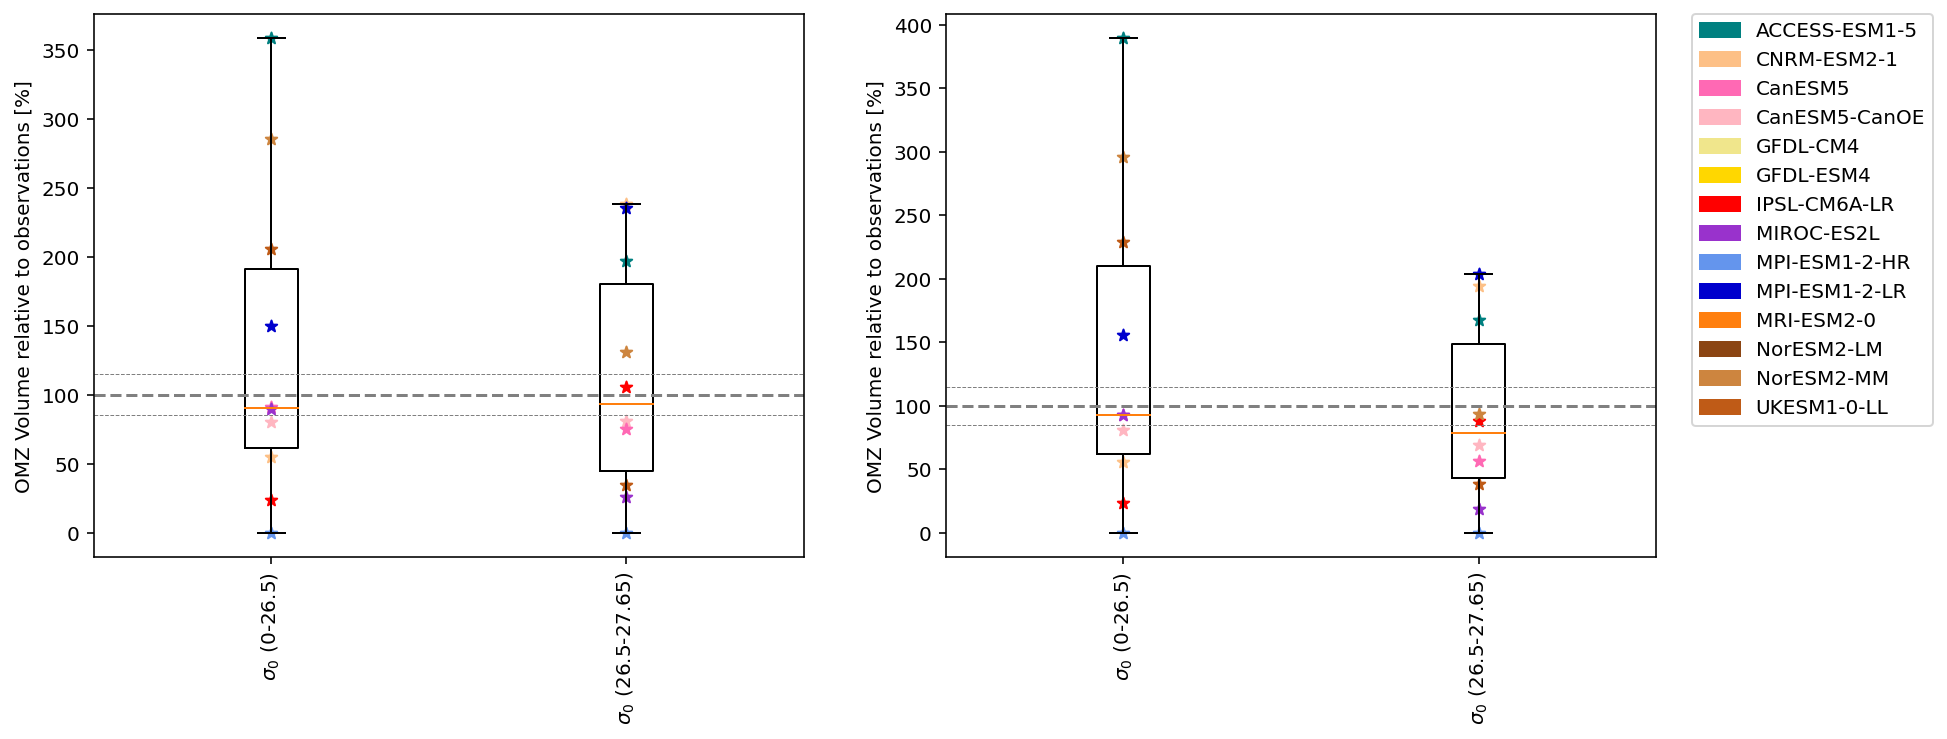

In [15]:
#violinplots
# sigma_bins = [0, 24.5, 26.5, 27.65, 30]

# sigma_bins = [0, 26.0, 26.5,27.0, 27.65] # last bin division by 0 makes for huuuuge values
sigma_bins = [0, 26.5, 27.65]

fig, axarr = plt.subplots(figsize=[14, 5], ncols=2, nrows=1)
for pi, (title, ds) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics, vol_integrated_full])):
    ax = axarr.flat[pi] 
    
    if title == 'tropical':
        obs = prep(woa_sigma, True)
    elif title == 'full':
        obs = prep(woa_sigma, False)
    
    x_labels = []
    for s_idx in range(len(sigma_bins)-1):
        sigma_upper = sigma_bins[s_idx]
        sigma_lower = sigma_bins[s_idx+1]
        da_obs = obs.sel(sigma_0=slice(sigma_upper, sigma_lower)).sum('sigma_0')
        data = []
        for mi, model in enumerate(results.keys()):
            da = ds[model].sel(experiment='fixed_o2').isel(time=0) # they are all the same
            da = da.sel(sigma_0=slice(sigma_upper, sigma_lower)).sum('sigma_0')
            # express as percentage of historical volume
            da = da/da_obs*100
            ax.scatter(s_idx, da, marker='*', color=o2_model_colors()[model])
            data.append(da.data)
        ax.boxplot([data], vert=True, positions=[s_idx])
        x_labels.append(f"$\sigma_0$ ({sigma_upper}-{sigma_lower})")
    ax.axhline(100, color='0.5', ls='--')
    ax.axhline(115, color='0.5', ls='--', lw=0.5)
    ax.axhline(85, color='0.5', ls='--', lw=0.5)
    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_ylabel('OMZ Volume relative to observations [%]')
model_color_legend()

In [ ]:
#violinplots
# sigma_bins = [0, 24.5, 26.5, 27.65, 30]

# sigma_bins = [0, 26.0, 26.5,27.0, 27.65] # last bin division by 0 makes for huuuuge values
sigma_bins = [0, 26.5, 27.65]

fig, axarr = plt.subplots(figsize=[14, 5], ncols=2, nrows=1)
for pi, (title, ds) in enumerate(zip(['tropical', 'full'],[vol_integrated_tropics, vol_integrated_full])):
    ax = axarr.flat[pi] 
    
    if title == 'tropical':
        obs = prep(woa_sigma, True)
    elif title == 'full':
        obs = prep(woa_sigma, False)
    
    x_labels = []
    for s_idx in range(len(sigma_bins)-1):
        sigma_upper = sigma_bins[s_idx]
        sigma_lower = sigma_bins[s_idx+1]
        da_obs = obs.sel(sigma_0=slice(sigma_upper, sigma_lower)).sum('sigma_0')
        data = []
        for mi, model in enumerate(results.keys()):
            da = ds[model].sel(experiment='fixed_o2').isel(time=0) # they are all the same
            da = da.sel(sigma_0=slice(sigma_upper, sigma_lower)).sum('sigma_0')
            # express as percentage of historical volume
            da = da/da_obs*100
            ax.scatter(s_idx, da, marker='*', color=o2_model_colors()[model])
            data.append(da.data)
        ax.boxplot([data], vert=True, positions=[s_idx])
        x_labels.append(f"$\sigma_0$ ({sigma_upper}-{sigma_lower})")
    ax.axhline(100, color='0.5', ls='--')
    ax.axhline(115, color='0.5', ls='--', lw=0.5)
    ax.axhline(85, color='0.5', ls='--', lw=0.5)
    ax.set_xticklabels(x_labels, rotation=90)
    ax.set_ylabel('OMZ Volume relative to observations [%]')
model_color_legend()

In [1]:
for mi, model in enumerate(results.keys()):
    plt.figure()
    ds = results[model]
    da = prep(ds, False, summed=False)
    fixed = da.sel(experiment='fixed_o2')
    variable = da.sel(experiment='variable_o2')
    decomposed = variable - fixed
    decomposed_upper = decomposed.sel(sigma_0=slice(0, 27.65)).sum('sigma_0')
    decomposed_trend = linear_trend(decomposed_upper.sel(time=slice('2000', '2100')), 'time').slope *100
    (decomposed_trend/decomposed_trend.areacello).plot(vmax=150, center=0)
    plt.title(model)
    plt.show()

NameError: name 'results' is not defined